# Part 2

### ALWAYS run this code below first 

In [29]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

# Helper functions
def is_integer(x):
   
    try:
        return (int(x) == float(x))
    except:
        return False

def ingest_files(directory: str):
    
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print(" Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print(" Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

def visualize_columns(data, float_cols, cat_cols, date_cols):
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # FLoat columns
    for i in float_cols:
        seaborn.boxplot(data[i])

        # Print the three highest values
        highest_vals = sorted(data[i], reverse=True)[:3]
        smallest_val = min(data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(data[i]))) + " distinct values")
        print(data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        data[data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(data[i].isnull().sum()) + " null values)")
        plt.show()

# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id",
                "loan_amnt",
                "funded_amnt",
                "revol_util",
                "revol_bal",
                "fico_range_low",
                "fico_range_high",
                "pub_rec",
                "open_acc",
                "earliest_cr_line",
                "delinq_2yrs",
                "dti",
                "purpose",
                "issue_d",
                "annual_inc",
                "home_ownership",
                "emp_length",
                "grade",
                "term",
                "int_rate",
                "installment",
                "verification_status",
                "recoveries",
                "loan_status",
                "last_pymnt_d",
                "total_pymnt"]

# Identify the type of each of these column

float_cols = ["loan_amnt",
                "funded_amnt",
                "revol_bal",
                "fico_range_low",
                "fico_range_high",
                "pub_rec",
                "open_acc",
                "delinq_2yrs",
                "dti",
                "annual_inc",
                "installment",
                "recoveries",
                "total_pymnt"]

cat_cols = ["purpose",
            "home_ownership",
            "emp_length",
            "grade",
            "term",
            "verification_status",
            "loan_status"]

perc_cols = ["revol_util",
             "int_rate"]

date_cols = ["earliest_cr_line",
             "issue_d",
             "last_pymnt_d"]


# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

# Define the names of the four returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

# Some of the columns selected will not be used directly in the model, but will be used to generate other features.
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

# Question 1

In [30]:
# Read in data
print ("Reading in data...")

# Define the directories that contain the full dataset files downloaded in 2019
dir_full = "/".join(["Data"] + ["full_dataset"] )

# Ingest the set of files
files_full = ingest_files(dir_full)
data_all = pd.concat(files_full.values()).reset_index(drop = True)

# Keep only the columns we care about
final_data = data_all[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Reading in data...
Directory Data/full_dataset/ has 15 files:
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q3.csv
 Found 2 invalid rows which were removed
 Re

In [31]:
new_data = data_all[['total_pymnt', 'total_pymnt_inv']].copy()
new_data.head()


,total_pymnt,total_pymnt_inv
0,7268.1531646293,7268.15
1,23643.13,23643.13
2,7223.41,7223.41
3,8448.9,8448.90
4,14331.0349132191,14331.03


# Question 2

In [32]:
# Read in data
print ("Reading in data...")

# Tell where the directories that contain the files downloaded in 2017 and 2019
dir_2017 = "/".join(["Data"] + ["1712_download"] )
dir_2019 = "/".join(["Data"] + ["1912_download"] )

# Ingest the set of files downloaded in 2017 and then the files downloaded in 2019
files_2017 = ingest_files(dir_2017)
files_2019 = ingest_files(dir_2019)

Reading in data...
Directory Data/1712_download/ has 8 files:
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
Directory Data/1912_download/ has 8 files:
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 

In [33]:
# Check the two sets of files have the same number of files
# with the same names
assert len(files_2017) == len(files_2019)
assert sorted(files_2017) == sorted(files_2019)

# Ensure each set of files has the same loan IDs in both instances
for i in files_2017:
    assert sorted(files_2017[i].id) == sorted(files_2019[i].id)
    

data_2017 = pd.concat(files_2017.values()).reset_index(drop = True)
data_2019 = pd.concat(files_2019.values()).reset_index(drop = True)

print("Loading complete, let's compare columns...")
print(set(data_2017.columns) - set(data_2019.columns))

print("Looks like disbursement_method is not found on 2019 data, we will remove this column.")

# There is somethings that not quite right
# 2017 dataset has an additional column which is disbursement_method
data_2017.drop(['disbursement_method'], axis=1, inplace=True)

print("Now we will merge the two datasets to compare...")

# Ensure the loan IDs are a unique key
assert len(set(data_2019.id)) == len(data_2019)
assert len(set(data_2017.id)) == len(data_2017)

# Ensure columns are same
columns = list(data_2017.columns)
assert sorted(columns) == sorted(data_2019.columns)

# Just in case, check the datasets have the same number of rows
n_rows = len(data_2017)
assert n_rows == len(data_2019)

# Merge them
combined = pd.merge(data_2017, data_2019, how = 'inner', on="id", suffixes=('_x', '_y'))

# Ensure the merged dataset has the same number of rows
assert n_rows == len(combined)

print("Let's look for static columns...")

# Go through each column, and find what percentage of the values in
# that column are identical in the two datasets
static_perc = {}

# Remove the ID column first
columns = [i for i in columns if i != "id"]

for i in columns:
    combined[i+"_comp"] = (combined[i+"_x"] == combined[i+"_y"]) | (combined[i+"_x"].isnull() & combined[i+"_y"].isnull())
    static_perc[i] = combined[i+"_comp"].sum()*100.0/len(combined)
    
static_perc_data = pd.DataFrame([ [i, static_perc[i]] for i in static_perc], columns=["column", "perc_equal"]).\
                                                    sort_values("perc_equal", ascending = False)

# Ensure that the columns we want to pick for our model are in
# the above, and check how consistent they've been
assert set(cols_to_pick) - set(static_perc_data.column) - set(["id"]) == set()

print("Below is the percentange of data for each of our columns that is the same:")

print(static_perc_data[static_perc_data.column.isin(cols_to_pick)])


Loading complete, let's compare columns...
{'disbursement_method'}
Looks like disbursement_method is not found on 2019 data, we will remove this column.
Now we will merge the two datasets to compare...
Let's look for static columns...
Below is the percentange of data for each of our columns that is the same:
                 column  perc_equal
1             loan_amnt  100.000000
32              pub_rec  100.000000
31             open_acc  100.000000
27      fico_range_high  100.000000
26       fico_range_low  100.000000
25     earliest_cr_line  100.000000
24          delinq_2yrs  100.000000
23                  dti  100.000000
19              purpose  100.000000
34           revol_util  100.000000
14              issue_d  100.000000
12           annual_inc  100.000000
11       home_ownership  100.000000
10           emp_length  100.000000
7                 grade  100.000000
4                  term  100.000000
2           funded_amnt  100.000000
33            revol_bal  100.000000
5     

In [34]:
# There are 35 rows where the int_rate_comp and installment_comp values do not have same comparison
(combined["int_rate_comp"] != combined["installment_comp"]).sum()

# what do you notice looking at these loans?
combined.loc[(combined["int_rate_comp"] != combined["installment_comp"]),:].loc[:,['id','int_rate_x','int_rate_y','term_x','term_y','installment_x','installment_y']]

,id,int_rate_x,int_rate_y,term_x,term_y,installment_x,installment_y
39618,74722704,10.75%,10.75%,60 months,60 months,432.36,405.03
88840,71003261,6.00%,11.16%,36 months,36 months,452.35,452.35
99418,70391991,6.00%,6.00%,36 months,36 months,655.91,653.38
102292,69980465,6.00%,6.00%,60 months,60 months,704.42,699.75
184837,78600054,13.67%,13.67%,60 months,60 months,461.96,441.9
198862,77538744,6.00%,6.00%,36 months,36 months,1032.57,1032.72
231097,76012596,6.00%,6.00%,60 months,60 months,467.41,461.68
295368,86136443,14.49%,14.49%,60 months,60 months,258.76,134.1
320463,83709004,19.99%,19.99%,60 months,60 months,303.04,279.86
384458,93413738,12.74%,12.74%,36 months,36 months,211.49,195.32


In [35]:
# So the differences in int_rate and installment are the same. Let's look at them
combined[combined.int_rate_comp == False][["id", "issue_d_x", "issue_d_y", "term_x", "term_y", "int_rate_x", "int_rate_y"]]

,id,issue_d_x,issue_d_y,term_x,term_y,int_rate_x,int_rate_y
11702,75132541,Mar-2016,Mar-2016,60 months,60 months,7.89%,6.00%
12709,74131643,Mar-2016,Mar-2016,36 months,36 months,6.97%,6.00%
18972,75101560,Mar-2016,Mar-2016,60 months,60 months,19.53%,6.00%
20946,75314580,Mar-2016,Mar-2016,60 months,60 months,10.75%,6.00%
26817,74522695,Mar-2016,Mar-2016,60 months,60 months,18.99%,6.00%
...,...,...,...,...,...,...,...
862147,118169441,Oct-2017,Oct-2017,60 months,60 months,18.06%,6.00%
862390,120953984,Oct-2017,Oct-2017,36 months,36 months,14.08%,6.00%
867463,120631915,Oct-2017,Oct-2017,60 months,60 months,9.93%,6.00%
871222,120554473,Oct-2017,Oct-2017,36 months,36 months,12.62%,6.00%


# Question 3

In [38]:
# Read in data
print ("Reading in data...")

# Define the directories that contain the full dataset files downloaded in 2019
dir_full = "/".join(["Data"] + ["full_dataset"] )

# Ingest the set of files
files_full = ingest_files(dir_full)
data_all = pd.concat(files_full.values()).reset_index(drop = True)

# Keep only the columns we care about
final_data = data_all[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Reading in data...
Directory Data/full_dataset/ has 15 files:
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2018Q3.csv
 Found 2 invalid rows which were removed
 Re

In [39]:
print("Starting with " + str(len(final_data)) + " rows")
print("Casting column types...")
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None
    
print("Removing null columns...")
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

print("Removing unfinished loans...")
# select only terminated loans
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

# Only include loans isssued since 2011
print("Removing loans older than 2011...")
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2011, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")


print("Ending with " + str(len(final_data)) + " rows")

print("Saving pickle file...")
# Define the output path for the pickle
pickle_file = "/".join(["Data"] + ["clean_data.pickle"] )

pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )
print("Saved to Data/clean_data.pickle")

Starting with 1763077 rows
Casting column types...
Removing null columns...
Removed 6794 rows
Removing unfinished loans...
Removed 975384 rows
Removing loans older than 2011...
Removed 0 rows
Ending with 787693 rows
Saving pickle file...
Saved to Data/clean_data.pickle


# Question 4

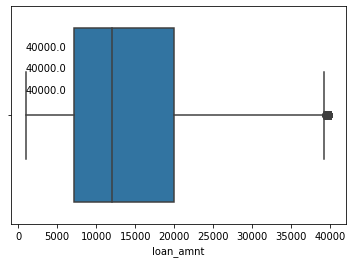

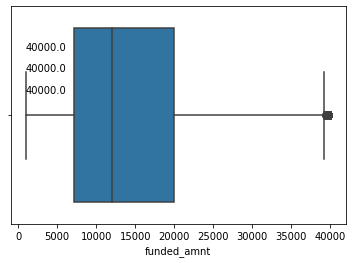

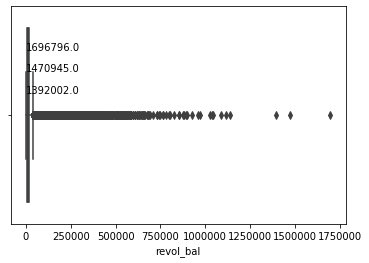

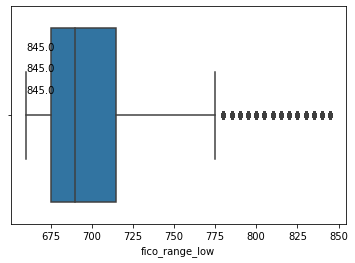

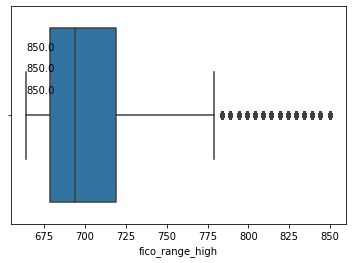

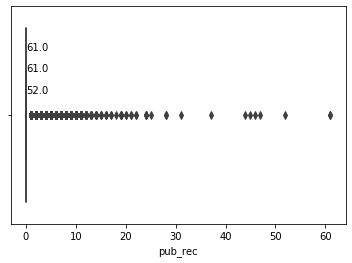

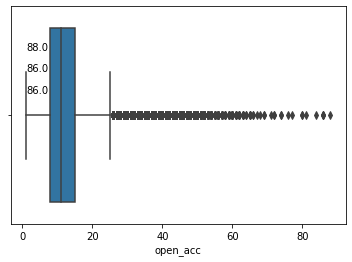

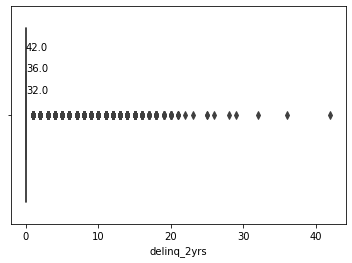

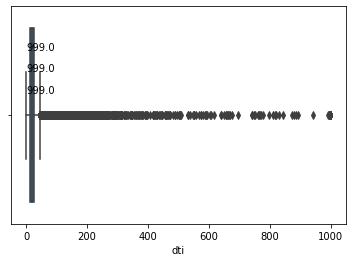

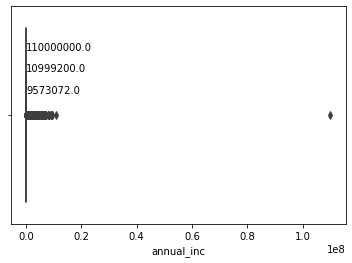

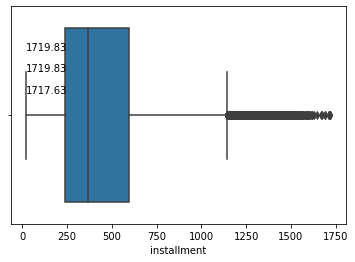

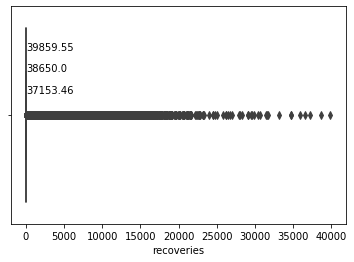

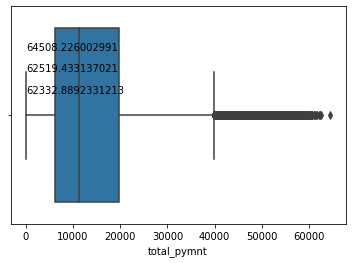

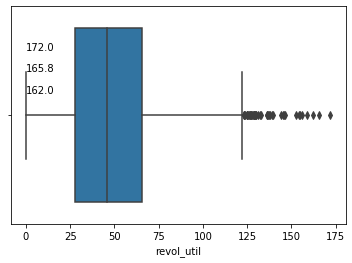

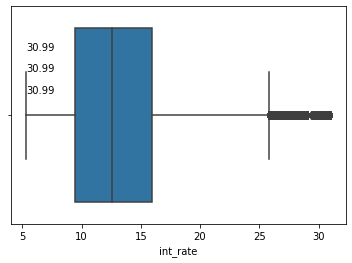

purpose
14 distinct values
debt_consolidation    440696
credit_card           163934
home_improvement       58666
other                  56638
major_purchase         19758
medical                11125
car                     9180
small_business          8306
vacation                6772
moving                  6273
house                   5781
renewable_energy         557
wedding                    6
educational                1
Name: purpose, dtype: int64


home_ownership
5 distinct values
MORTGAGE    386784
RENT        304481
OWN          95732
ANY            692
NONE             4
Name: home_ownership, dtype: int64


emp_length
12 distinct values
10+ years    262277
2 years       72475
< 1 year      65250
3 years       63952
1 year        53068
5 years       48463
4 years       48005
6 years       34140
8 years       29213
9 years       27409
7 years       27139
Name: emp_length, dtype: int64


grade
7 distinct values
B    234953
C    232657
A    148542
D    110686
E     42237
F    

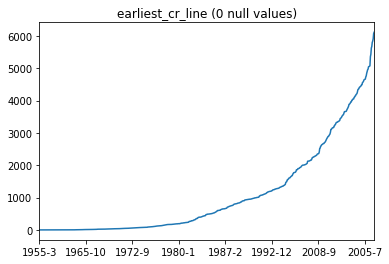

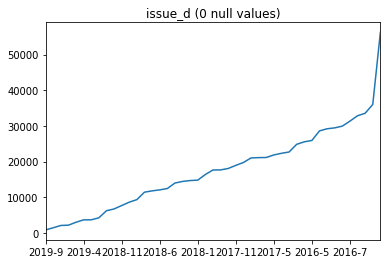

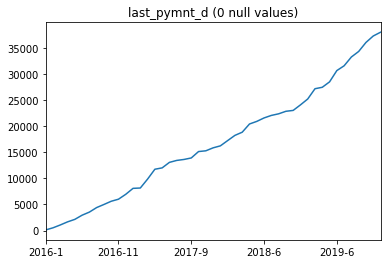

In [40]:
# Visualize the data
visualize_columns(final_data, float_cols + perc_cols, cat_cols, date_cols)

Removed 7 rows


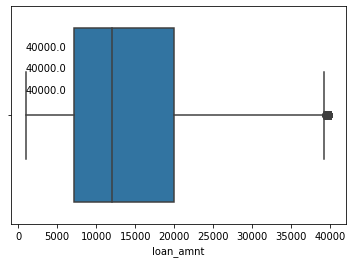

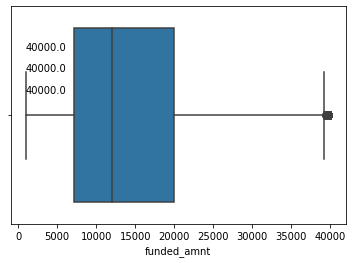

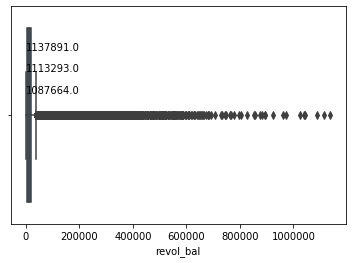

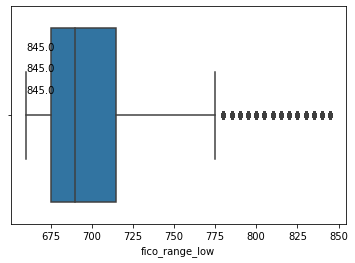

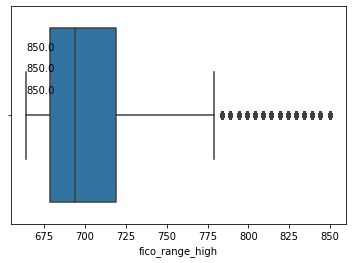

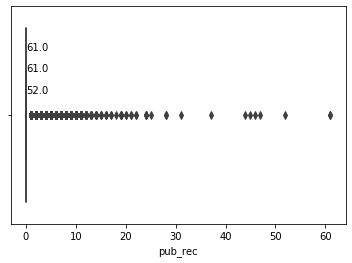

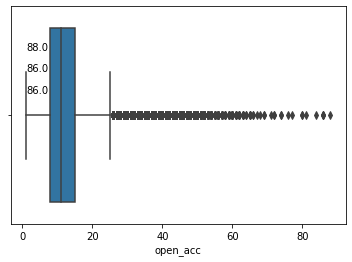

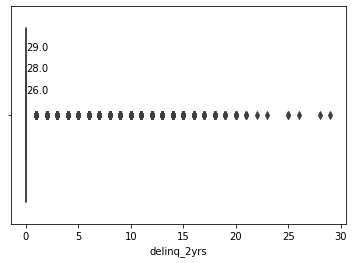

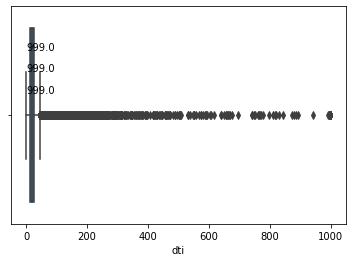

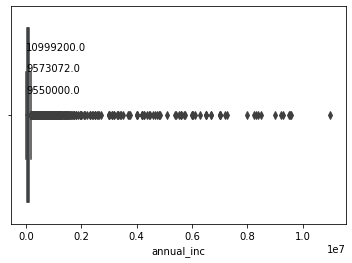

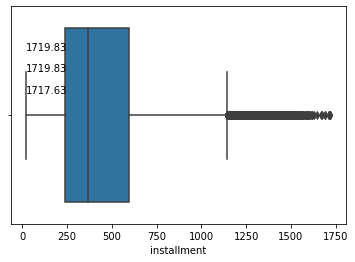

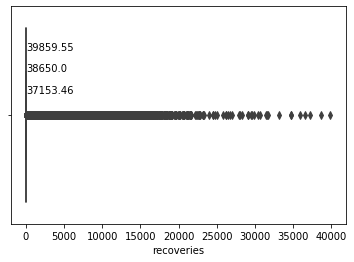

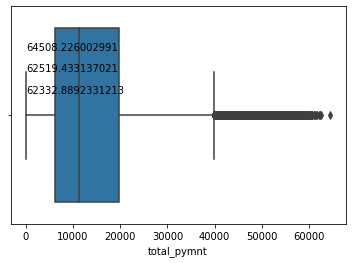

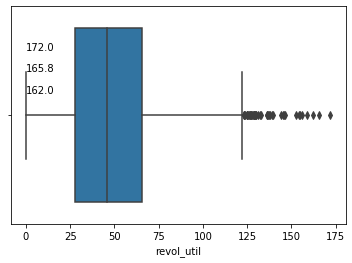

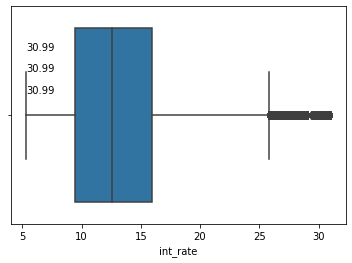

purpose
14 distinct values
debt_consolidation    440695
credit_card           163931
home_improvement       58664
other                  56638
major_purchase         19758
medical                11125
car                     9180
small_business          8305
vacation                6772
moving                  6273
house                   5781
renewable_energy         557
wedding                    6
educational                1
Name: purpose, dtype: int64


home_ownership
5 distinct values
MORTGAGE    386779
RENT        304479
OWN          95732
ANY            692
NONE             4
Name: home_ownership, dtype: int64


emp_length
12 distinct values
10+ years    262273
2 years       72475
< 1 year      65250
3 years       63951
1 year        53068
5 years       48463
4 years       48005
6 years       34140
8 years       29213
9 years       27409
7 years       27139
Name: emp_length, dtype: int64


grade
7 distinct values
B    234951
C    232656
A    148541
D    110685
E     42235
F    

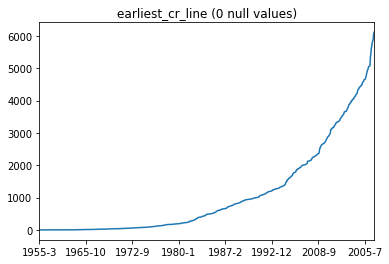

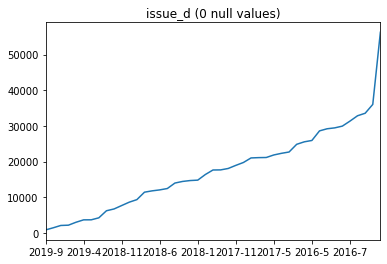

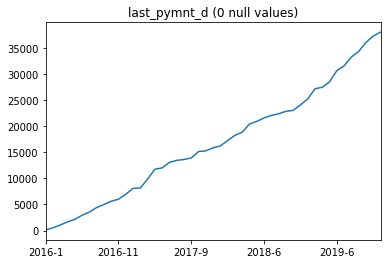

In [41]:
# Remove outliers and then vizualize the data again
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 100000000]
final_data = final_data[final_data.revol_bal < 1250000]
final_data = final_data[final_data.delinq_2yrs < 32]
print("Removed " + str(n_rows - len(final_data)) + " rows")

# Visualize the data
visualize_columns(final_data, float_cols + perc_cols, cat_cols, date_cols)

# Part 3

# Questuion 1

In [42]:
print("Reading in pickle file...")

final_data, discrete_features, continuous_features, ret_cols = pickle.load( open( "Data/clean_data.pickle", "rb" ) )

final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")


Reading in pickle file...
Removed 10427 rows


In [43]:
final_data['total'] = ((final_data.installment * round(final_data.loan_length)))
final_data.loc[(final_data["recoveries"] != 0),:].loc[:,['loan_status', 'funded_amnt', 'term', 'total', 'total_pymnt', 'recoveries', 'int_rate','loan_length']]


,loan_status,funded_amnt,term,total,total_pymnt,recoveries,int_rate,loan_length
3,Charged Off,12000.0,60 months,8540.16,8448.90,443.49,11.99,32.033512
11,Charged Off,9000.0,36 months,3816.67,4365.68,853.35,10.75,13.010534
15,Charged Off,20000.0,36 months,7649.88,8797.98,1805.95,9.16,11.992033
18,Charged Off,9600.0,36 months,12409.66,11062.23,250.00,13.67,37.980246
22,Charged Off,21000.0,36 months,13573.03,16700.62,3873.86,13.67,19.022978
...,...,...,...,...,...,...,...,...
1488154,Charged Off,4000.0,36 months,150.48,724.20,563.36,20.89,1.018501
1488172,Charged Off,10000.0,60 months,264.50,1668.07,1414.64,19.92,1.018501
1488722,Charged Off,23875.0,36 months,2271.33,2954.11,25.00,8.81,2.956940
1494872,Charged Off,36825.0,60 months,801.04,9991.23,9212.74,11.02,0.985647


# Question 2

# Return Method 1 (pessimistic)

In [44]:
# Calculate the return using a simple annualized profit margin
# Pessimistic fefinition (method 2)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt - final_data.funded_amnt) 
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

# Return Method 2 (optimistic)

In [45]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 2 to compute the return

final_data['ret_OPT'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]

# Method 3 (re-investment)

In [46]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )


# T should be term here in months. We can get this value from term_num which was calculated earlier
final_data['term_num']

final_data['ret_INTa'] = ret_method_3(final_data['term_num'], 1.2/100) # 1.2%
final_data['ret_INTb'] = ret_method_3(final_data['term_num'], 3/100) # 3%
## final_data['ret_INTc'] = ret_method_3(?, ?) # We don't need this I don't think

# Mean and Median Results

In [47]:
def print_median_mean(data, value):
    mean = data[value].mean()*100;
    median = data[value].median()*100
    print("\tMean: " + str(mean))
    print("\tMedian: " + str(median))


print("Method 1 Pesimistic results:")
print_median_mean(final_data, 'ret_PESS')
    
print("Method 2 Optimisic results:")
print_median_mean(final_data, 'ret_OPT')

print("Method 3 (1.2%):")
print_median_mean(final_data, 'ret_INTa')

print("Method 3 (3%):")
print_median_mean(final_data, 'ret_INTb')

Method 1 Pesimistic results:
	Mean: 0.04157332049195786
	Median: 2.7863924675738607
Method 2 Optimisic results:
	Mean: 4.924544570329196
	Median: 7.476474863868679
Method 3 (1.2%):
	Mean: 13.209380349514971
	Median: 17.644040016278385
Method 3 (3%):
	Mean: 46.793771973857005
	Median: 49.544620318194106


# Question 3

In [48]:
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 )
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 )
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 )
# ret_by_grade_INTc = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTc)*100 )
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
# combined['return_INTc'] = ret_by_grade_INTc

combined['count'] = combined['grade']/100 * len(final_data)
#len(final_data)
combined

,grade,default,int_rate,return_OPT,return_PESS,return_INTa,return_INTb,count
A,18.878608,6.688156,6.981119,3.850003,1.036243,13.964298,44.180124,146737.0
B,29.852586,14.920227,10.477369,4.647929,0.764194,13.727066,45.465953,232034.0
C,29.545098,24.604170,14.113935,5.069478,-0.179073,13.113111,47.799174,229644.0
D,14.000484,33.379587,18.758675,5.754727,-1.230543,12.113887,48.077860,108821.0
E,5.363158,41.582306,23.610692,6.634144,-1.741258,11.986214,51.456900,41686.0
F,1.727337,50.357515,27.434500,6.456103,-2.456857,11.371310,53.871506,13426.0
G,0.632731,54.005693,29.965842,6.227061,-3.346234,10.381430,53.216044,4918.0


In [49]:
from scipy.stats import kurtosis, skew

def print_kurtosis_skewness(data, value):
    k = kurtosis(data[value]);
    s = skew(data[value])
    print("\tKurtosis: " + str(k))
    print("\tSkewness: " + str(s))

print('Interest Rate results')
print_kurtosis_skewness(final_data, 'int_rate')

print("Method 1 Pesimistic results:")
print_kurtosis_skewness(final_data, 'ret_PESS')

print("Method 2 Optimisic results:")
print_kurtosis_skewness(final_data, 'ret_OPT')

print('Method 3 (1.2%)')
print_kurtosis_skewness(final_data, 'ret_INTa')

print('Method 3 results (3%)')
print_kurtosis_skewness(final_data, 'ret_INTb')

Interest Rate results
	Kurtosis: 0.7923193787702627
	Skewness: 0.9274066932504201
Method 1 Pesimistic results:
	Kurtosis: 2.1895256579179883
	Skewness: -1.7151026655056627
Method 2 Optimisic results:
	Kurtosis: 1.1258894162746378
	Skewness: -1.019713657545549
Method 3 (1.2%)
	Kurtosis: 1.836033439040972
	Skewness: -1.6591283502486942
Method 3 results (3%)
	Kurtosis: 0.24431715900694284
	Skewness: -0.25928553401635884
